# making animation for github

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cmocean
import xarray as xa

import sys,os
testdir = os.path.dirname(os.getcwd() + '/')
srcdir = '..'
sys.path.insert(0, os.path.abspath(os.path.join(testdir, srcdir)))
from ocean_wave_tracing import Wave_tracing

%matplotlib inline

In [2]:
# READ INPUT DATA
ncin = xa.open_dataset('idealized_input.nc')
idt0=15 #22

# Current forcing

In [3]:
X = ncin.x.data
Y = ncin.y.data
nx = len(X)
ny = len(Y)
dx=dy=X[1]-X[0]
nb_wave_rays = 200#550#nx
T = 3000
nt = 190 # 1500
wave_period = 10 #s
X0, XN = X[0], X[-1] 
Y0, YN = Y[0], Y[-1]

i_w_side = 'left'
theta0=0

In [4]:
# EDDY
wt_eddy = Wave_tracing(ncin.U[idt0::,:,:], ncin.V[idt0::,:,:], nx, ny, nt,T,dx,dy, nb_wave_rays=nb_wave_rays,
                     domain_X0=X0, domain_XN=XN,
                     domain_Y0=Y0, domain_YN=YN,
                     )
wt_eddy.set_initial_condition(wave_period, theta0,incoming_wave_side=i_w_side)
wt_eddy.solve()

In [5]:
# Jet
wt_jet = Wave_tracing(ncin.U_jet[:,:], ncin.V_zero[idt0,:,:], nx, ny, nt,T,dx,dy,nb_wave_rays=nb_wave_rays,
                     domain_X0=X0, domain_XN=XN,
                     domain_Y0=Y0, domain_YN=YN,
                     )
wt_jet.set_initial_condition( wave_period, theta0, incoming_wave_side=i_w_side)
wt_jet.solve()
ds_jet_left=wt_jet.to_ds()



In [6]:
#Opposing jet
wt_jet_o = Wave_tracing(ncin.U_jet[:,:], ncin.V_zero[idt0,:,:], nx, ny, nt,T,dx,dy,nb_wave_rays=nb_wave_rays,
                     domain_X0=X0, domain_XN=XN,
                     domain_Y0=Y0, domain_YN=YN,
                     )
wt_jet_o.set_initial_condition( wave_period, np.pi,incoming_wave_side='right')
wt_jet_o.solve()
ds_jet_right=wt_jet_o.to_ds()

In [7]:
# constant slope bottom lower right
wt_cs_lr = Wave_tracing(ncin.U_zero[idt0,:,:], ncin.V_zero[idt0,:,:], nx, ny, nt,T,dx,dy, nb_wave_rays=nb_wave_rays,
                        domain_X0=X0, domain_XN=XN,
                        domain_Y0=Y0, domain_YN=YN,
                        d=ncin.bathymetry_bm.data)
wt_cs_lr.set_initial_condition( wave_period,  np.linspace(np.pi/10,0.66*np.pi,nb_wave_rays),ipx=float(5000),ipy=float(2000),)
wt_cs_lr.solve()

In [8]:
#plotting params
fs=15
s_max=0.4 #max speed

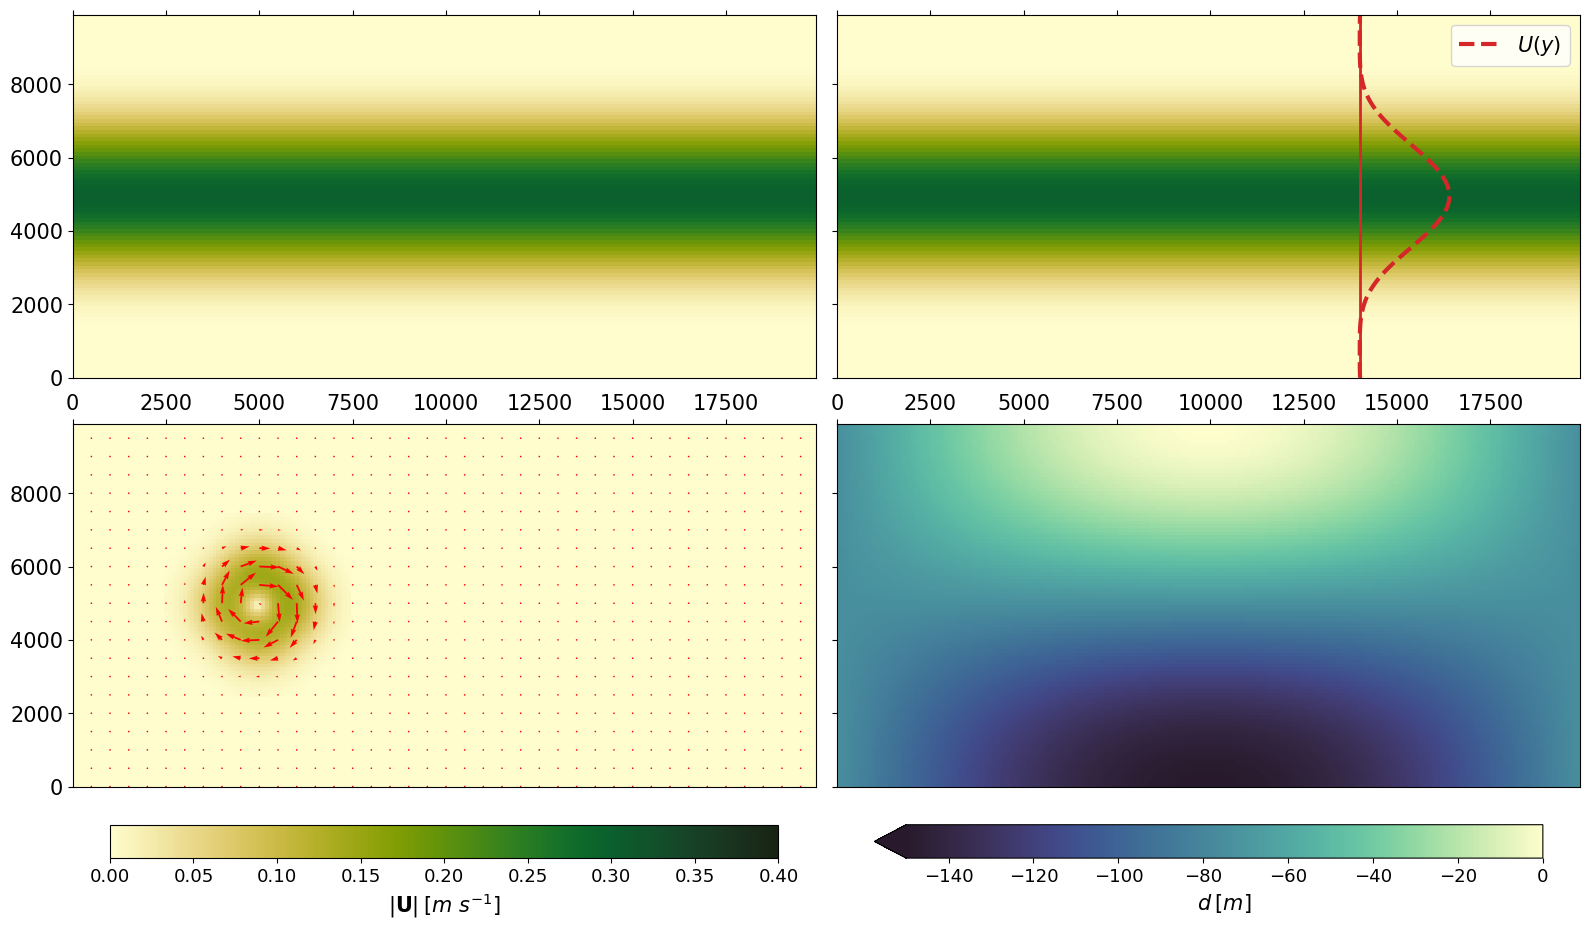

In [11]:
fig,ax = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True,figsize=(16,10),)

cases = [ds_jet_left, ds_jet_right, wt_eddy, wt_cs_lr]

idt = np.arange(0,nt,30)

pc=ax[0,0].pcolormesh(wt_jet.x,wt_jet.y,wt_jet.U[0,:,:],shading='auto',cmap=cmocean.cm.speed,vmin=0,vmax=s_max)

pc1=ax[0,1].pcolormesh(wt_jet.x,wt_jet.y,wt_jet.U[0,:,:],shading='auto',cmap=cmocean.cm.speed,vmin=0,vmax=s_max)


pc3=ax[1,0].pcolormesh(wt_eddy.x,wt_eddy.y,ncin.speed[idt0,:,:],shading='auto',cmap=cmocean.cm.speed,
                   vmin=0,vmax=s_max)

q_step = 5
qu=ax[1,0].quiver(wt_eddy.x[::q_step],wt_eddy.y[::q_step],
                  wt_eddy.U[0,::q_step,::q_step],wt_eddy.V[0,::q_step,::q_step],
                  color='r', scale=5)

pc2=ax[1,1].pcolormesh(wt_cs_lr.x,wt_cs_lr.y,-wt_cs_lr.d[:,:],shading='auto',cmap=cmocean.cm.deep_r,vmin=-150,vmax=0)

for aax in ax.flatten():
    aax.tick_params(labelsize=fs)
    aax.xaxis.tick_top()

ax[0,0].set_xlim([X0,XN])
ax[0,0].set_ylim([Y0,YN])



ax[0,1].plot(wt_jet.x[140]+wt_jet.U[0,:,10]*8000,wt_jet.y,lw=3, ls='--', c='tab:red',label=r'$U(y)$')
ax[0,1].plot(wt_jet.x[140]+wt_jet.U[0,:,10]*0,wt_jet.y,lw=2, ls='-', c='tab:red')
ax[0,1].legend(fontsize=fs,loc='upper right')

fig.tight_layout()

cb1=fig.colorbar(pc, ax=[ax[0,0],ax[1,0]], orientation='horizontal',shrink=0.9, pad=0.04)
cb2=fig.colorbar(pc2, ax=[ax[0,1],ax[1,1]], orientation='horizontal',shrink=0.9, extend='min', pad=0.04)
cb1.set_label(r'$|\mathbf{U}| \: [m~s^{-1}]$',fontsize=fs)
cb2.set_label(r'$d \: [m]$',fontsize=fs)
cb1.ax.tick_params(labelsize=fs-2) 
cb2.ax.tick_params(labelsize=fs-2) 

#fig.savefig('/home/trygveh/documents/phd/papers/wave_ray_tracing/figures/current_refraction_examples.png',dpi=170)


def update(idt):

    counter = 0
    
    for r_id in range(0,wt_jet.nb_wave_rays,15):        
        ax[0,0].plot(wt_jet.ray_x[r_id,0:idt],wt_jet.ray_y[r_id,0:idt],'-k',alpha=0.6)
        ax[0,1].plot(wt_jet_o.ray_x[r_id,0:idt],wt_jet_o.ray_y[r_id,0:idt],'-k',alpha=0.6)
        ax[1,0].plot(wt_eddy.ray_x[r_id,0:idt],wt_eddy.ray_y[r_id,0:idt],'-k',alpha=0.6)
        ax[1,1].plot(wt_cs_lr.ray_x[r_id,0:idt],wt_cs_lr.ray_y[r_id,0:idt],'-k',alpha=0.6)


ani = animation.FuncAnimation(fig, update, interval=40,save_count=100)# blit=False, save_count=10)


In [12]:
ani.save("movie_rt_poc.gif")